# Importing Modules

In [25]:
%load_ext autotime

import yaml
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import preprocessing as pp
from datetime import datetime
import neptune.new as neptune
from tensorflow.keras import layers
from tensorflow.keras import metrics
from sklearn.pipeline import Pipeline
from gensim.models.word2vec import Word2Vec
from modelevaluation import modeleval as me
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

warnings.filterwarnings("ignore")

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 16 ms (started: 2022-02-01 18:18:01 +05:30)


# Importing Data

In [2]:
con_com_use = pd.read_csv('train.csv')

time: 109 ms (started: 2022-02-01 17:12:48 +05:30)


# Configuration

In [3]:
# Independent variables
INDEPENDENT_FEATURES = ['Consumer complaint narrative']

# Dependent variable
DEPENDENT_FEATURES = ['Product']

# Sample size
TRAIN_SIZE = 10000
TEST_SIZE = 3000

# Random state
RANDOM_STATE = 0

# Word2Vec config
PARAMS_WORD2VEC:{'VECTOR_SIZE':160,
                 'MIN_COUNT':2, # Minimum frequency of words to be used
                 'WINDOW':7, # Maximum distance between the current and predicted word within a sentence
                 'EPOCHS':50, # Number of iterations over the corpus
                 'SG':1}, # Training algo. 1 means skip-gram

# Padding size
MAX_LENGHT = 140

# Model parameters
PARAMS_LSTM = {'MODEL_NAME':'Bi-Directional-LSTM',
               'lr':0.0003,
               'epochs':100,
               'batch_size':512,
               'verbose':1,
               'validation_split':0.3}

time: 0 ns (started: 2022-02-01 17:12:48 +05:30)


In [28]:
!python datamodel-codegen  --input D:\Data Science\pythonProjects\MLPipeline\classification_model\tmp_tst.json --input-file -type jsonschema --output tst_tmp.py

time: 93 ms (started: 2022-02-02 14:55:33 +05:30)


python: can't open file 'datamodel-codegen': [Errno 2] No such file or directory


In [ ]:
config_out = {
    # Independent variables
    'INDEPENDENT_FEATURES': 'Consumer complaint narrative',
    
    # Dependent variable
    'DEPENDENT_FEATURES':'Product',
    
    # Random state
    'RANDOM_STATE':0,
    
    'TEST_SIZE':3000,
    
    # Word2Vec config
    'PARAMS_WORD2VEC':{'VECTOR_SIZE':160,
                       'MIN_COUNT':2, # Minimum frequency of words to be used
                       'WINDOW':7, # Maximum distance between the current and predicted word within a sentence
                       'EPOCHS':50, # Number of iterations over the corpus
                       'SG':1}, # Training algo. 1 means skip-gram
    
    # Padding size
    'MAX_LENGHT':140,
    
    # Model parameters
    'PARAMS_LSTM':{'MODEL_NAME':'Bi-Directional-LSTM',
                   'lr':0.0003,
                   'epochs':100,
                   'batch_size':512,
                   'verbose':1,
                   'validation_split':0.3}
    
}

# Package Overview
package_name: classification_model


# Data Files
training_data_file: train.csv
test_data_file: test.csv

pipeline_save_file: classification_model_output_v

# Dependent variable
DEPENDENT_FEATURES: Product

# Independent variables
INDEPENDENT_FEATURES: Consumer complaint narrative

# Padding size
MAX_LENGHT: 140

# Model parameters
PARAMS_LSTM:
  MODEL_NAME: Bi-Directional-LSTM
  batch_size: 512
  epochs: 100
  lr: 0.0003
  validation_split: 0.3
  verbose: 1

# Word2Vec config
PARAMS_WORD2VEC:
  EPOCHS: 50
  MIN_COUNT: 2
  SG: 1
  VECTOR_SIZE: 160
  WINDOW: 7

# Random state
RANDOM_STATE: 0

TEST_SIZE: 3000

# with open(r'D:\Data Science\pythonProjects\MLPipeline\classification_model\config.yaml', 'w') as file:
#     documents = yaml.dump(config_out, file)

# Train-test split

In [4]:
xtrain, xtest, ytrain, ytest = train_test_split(con_com_use[INDEPENDENT_FEATURES[0]],
                                                con_com_use[DEPENDENT_FEATURES[0]],
                                                stratify=con_com_use[DEPENDENT_FEATURES[0]],
                                                random_state=RANDOM_STATE,
                                                test_size=0.3)
print (xtrain.shape)
print (xtest.shape)

(7000,)
(3000,)
time: 16 ms (started: 2022-02-01 17:12:48 +05:30)


# Encoding Dependent Labels

In [5]:
lab_enc = LabelEncoder()

ytrain = lab_enc.fit_transform(ytrain)
ytest = lab_enc.transform(ytest)

ytrain_enc = to_categorical(ytrain)
ytest_enc = to_categorical(ytest)

time: 15 ms (started: 2022-02-01 17:12:48 +05:30)


# Preprocessing Pipeline

In [6]:
text_process_pipe = Pipeline([
    
    ('text_cleanup', pp.textcleanup()),
    
    ('text_tokenenize', pp.texttokenize()),
    
    ('text_stopwordremove', pp.textstopwordremove()),
    
    ('text_lemmatize', pp.textlemmatize()),
    
    ('text_stemmer', pp.textstemmer()),
    
    ('text_token', pp.texttokenize2(PARAMS_WORD2VEC['MAX_LENGHT'])),
    
])

text_process_pipe.fit(xtrain)

Pipeline(steps=[('text_cleanup', textcleanup()),
                ('text_tokenenize', texttokenize()),
                ('text_stopwordremove', textstopwordremove()),
                ('text_lemmatize', textlemmatize()),
                ('text_stemmer', textstemmer()),
                ('text_token', texttokenize2(variable=140))])

time: 22.9 s (started: 2022-02-01 17:12:48 +05:30)


In [7]:
xtrain = text_process_pipe.transform(xtrain)
xtest = text_process_pipe.transform(xtest)

word_index = eval(text_process_pipe.named_steps['text_token'].token.get_config()['word_index'])

time: 30.3 s (started: 2022-02-01 17:13:11 +05:30)


# Training a Word2Vec model

In [8]:
word2vecModel = Word2Vec(con_com_use[INDEPENDENT_FEATURES[0]].str.split(' ').tolist(),
                         min_count=PARAMS_WORD2VEC['MIN_COUNT'],
                         vector_size=PARAMS_WORD2VEC['VECTOR_SIZE'],
                         workers=12, 
                         window=PARAMS_WORD2VEC['WINDOW'], 
                         sg=PARAMS_WORD2VEC['SG'],
                         epochs=PARAMS_WORD2VEC['EPOCHS'])
gensim_embbed = dict(zip(word2vecModel.wv.index_to_key, word2vecModel.wv.vectors))

embedding_matrix = np.zeros((len(word_index) + 1, VECTOR_SIZE))
for word, i in word_index.items():
    embedding_vector = gensim_embbed.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

time: 1min 46s (started: 2022-02-01 17:13:41 +05:30)


# Bi-Directional LSTM

## Model Definition

In [10]:
modelLSTM = Sequential()
modelLSTM.add(layers.Embedding(len(word_index)+1,
                               VECTOR_SIZE,
                               weights=[embedding_matrix],
                               input_length=MAX_LENGHT,
                               trainable=False))

modelLSTM.add(layers.Bidirectional(layers.LSTM(512, dropout=0.2)))

modelLSTM.add(layers.Dense(1024, activation='relu'))
modelLSTM.add(layers.Dropout(0.8))

modelLSTM.add(layers.Dense(1024, activation='relu'))
modelLSTM.add(layers.Dropout(0.8))

modelLSTM.add(layers.Dense(8))
modelLSTM.add(layers.Activation('softmax'))
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=PARAMS_LSTM["lr"])
modelLSTM.compile(loss='categorical_crossentropy', optimizer=optimizer,
                  metrics=['accuracy',
                           metrics.CategoricalAccuracy(),
                           metrics.Precision(),
                           metrics.Recall()])
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0)

modelLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 140, 160)          1573120   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              2756608   
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 8

## Model registry config

In [11]:
run = neptune.init(
    project="kumars/Consumer-Complaint" # Neptune user name and project name
    # , source_files=['03_consumerComplaintClassification_CompletePipeline.ipynb', 'preprocessing.py'] # files to be tracked
) 

# log hyper-parameters
run['hyper-parameters'] = PARAMS_LSTM
run["sys/tags"].add([datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
                     'Model evaluation',
                     'LSTM Bidirectional',
                     'Sid'])
run["model"].upload(PARAMS_LSTM['MODEL_NAME']+'_model.h5')
neptune_clbk = NeptuneCallback(run=run, base_namespace='metrics') # Create callback for tracking the model training

https://app.neptune.ai/kumars/Consumer-Complaint/e/CON-18
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
time: 10.3 s (started: 2022-02-01 17:15:31 +05:30)


## Train model

In [12]:
modelLSTM.fit(xtrain,
              y=ytrain_enc,
              batch_size=PARAMS_LSTM['batch_size'],
              epochs=PARAMS_LSTM['epochs'],
              verbose=PARAMS_LSTM['verbose'],
              validation_split=PARAMS_LSTM['validation_split'],
              callbacks=[earlystop, neptune_clbk])

Epoch 1/100
10/10 [==============================] - 26s 548ms/step - loss: 1.9933 - accuracy: 0.2529 - categorical_accuracy: 0.2529 - precision: 0.2259 - recall: 0.0070 - val_loss: 1.6782 - val_accuracy: 0.3957 - val_categorical_accuracy: 0.3957 - val_precision: 0.6154 - val_recall: 0.1867
Epoch 2/100
10/10 [==============================] - 3s 338ms/step - loss: 1.7512 - accuracy: 0.3647 - categorical_accuracy: 0.3647 - precision: 0.5728 - recall: 0.0912 - val_loss: 1.5132 - val_accuracy: 0.3981 - val_categorical_accuracy: 0.3981 - val_precision: 0.6465 - val_recall: 0.3352
Epoch 3/100
10/10 [==============================] - 3s 333ms/step - loss: 1.5597 - accuracy: 0.4170 - categorical_accuracy: 0.4170 - precision: 0.7094 - recall: 0.2558 - val_loss: 1.4423 - val_accuracy: 0.4900 - val_categorical_accuracy: 0.4900 - val_precision: 0.8264 - val_recall: 0.2381
Epoch 4/100
10/10 [==============================] - 3s 318ms/step - loss: 1.4931 - accuracy: 0.4529 - categorical_accuracy: 0

time: 2min 40s (started: 2022-02-01 17:15:41 +05:30)


## Model Evaluation

Train


,class,precision,recall,f1_score,support
0,"Bank account or service, Savings account",0.66,0.78,0.72,503.00
1,"Consumer loan, Vehicle loan or lease, Payday l...",0.63,0.25,0.36,347.00
2,Credit card or prepaid card,0.84,0.65,0.73,767.00
3,"Credit reporting, credit repair services, or o...",0.82,0.91,0.86,2683.00
4,Debt collection,0.78,0.81,0.79,1435.00
5,"Money transfer, virtual currency, or money ser...",0.69,0.40,0.50,198.00
6,Mortgage,0.80,0.85,0.82,797.00
7,Student loan,0.77,0.74,0.76,270.00
8,accuracy,NaN,NaN,NaN,0.79
9,macro avg,0.75,0.67,0.69,7000.00


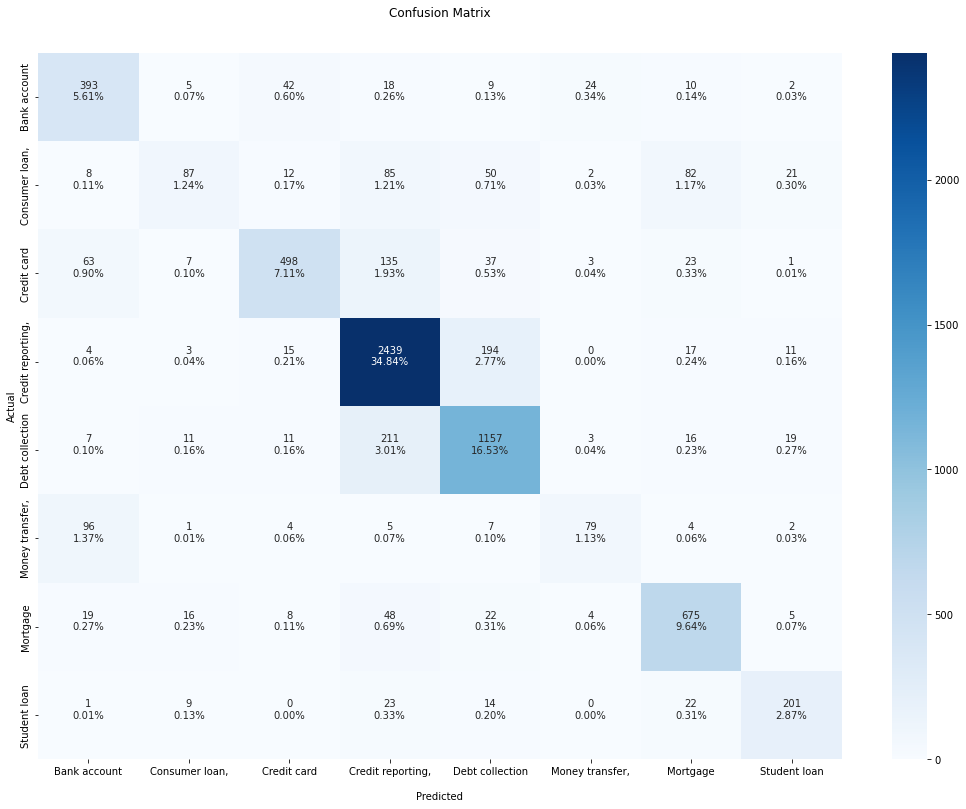



Test


,class,precision,recall,f1_score,support
0,"Bank account or service, Savings account",0.60,0.68,0.64,215.00
1,"Consumer loan, Vehicle loan or lease, Payday l...",0.48,0.21,0.29,149.00
2,Credit card or prepaid card,0.72,0.58,0.64,328.00
3,"Credit reporting, credit repair services, or o...",0.80,0.87,0.83,1150.00
4,Debt collection,0.73,0.77,0.75,615.00
5,"Money transfer, virtual currency, or money ser...",0.48,0.26,0.34,85.00
6,Mortgage,0.72,0.79,0.75,342.00
7,Student loan,0.75,0.67,0.71,116.00
8,accuracy,NaN,NaN,NaN,0.74
9,macro avg,0.66,0.60,0.62,3000.00


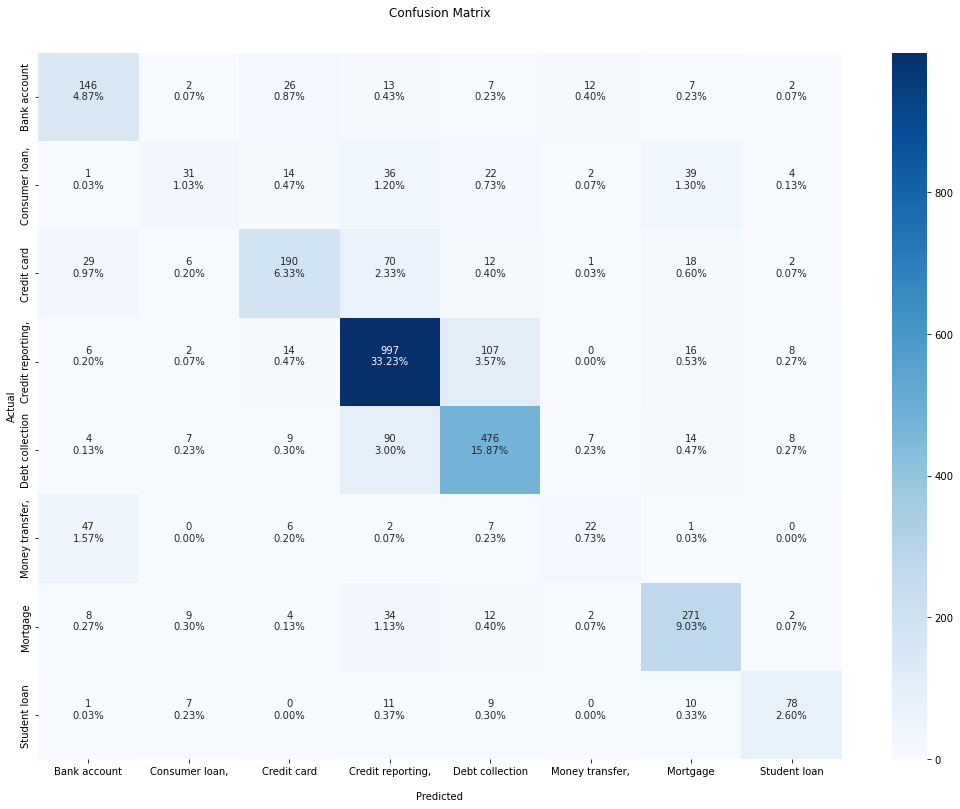

time: 6.84 s (started: 2022-02-01 17:18:21 +05:30)


In [13]:
# Run prediction on test and train 
ytrain_pred = np.argmax(modelLSTM.predict(xtrain), axis=-1)
ytrain_orig = np.argmax(ytrain_enc, axis=-1)
ytest_pred = np.argmax(modelLSTM.predict(xtest), axis=-1)
ytest_orig = np.argmax(ytest_enc, axis=-1)

print('Train')
train_classreport = me.classification_report_cust(ytrain_orig,
                                                  ytrain_pred,
                                                  list(lab_enc.classes_))
display(train_classreport)
train_classreport.to_csv(PARAMS_LSTM['MODEL_NAME']+'_train_classification_report.csv', index=False)
train_confmatrix = me.confusion_mat_plt(ytrain_orig,
                                        ytrain_pred,
                                        8,
                                        figs=(18,13),
                                        cat_names=list(lab_enc.classes_))
train_confmatrix.savefig(PARAMS_LSTM['MODEL_NAME']+'_train_confusionmatrix.png')

print('\n\nTest')
test_classreport = me.classification_report_cust(ytest_orig,
                                                 ytest_pred,
                                                 list(lab_enc.classes_))
display(test_classreport)
test_classreport.to_csv(PARAMS_LSTM['MODEL_NAME']+'_test_classification_report.csv', index=False)
test_confmatrix = me.confusion_mat_plt(ytest_orig,
                                       ytest_pred,
                                       8,
                                       figs=(18,13), 
                                       cat_names=list(lab_enc.classes_))
test_confmatrix.savefig(PARAMS_LSTM['MODEL_NAME']+'_test_confusionmatrix.png')

## Saving the trained model

In [15]:
modelLSTM.save(PARAMS_LSTM['MODEL_NAME']+'_model.h5') # Save the trained model
joblib.dump(text_process_pipe, 'text_process_pipe.joblib')

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 19 operations to synchronize with Neptune. Do not kill this process.


All 19 operations synced, thanks for waiting!
time: 8.66 s (started: 2022-02-01 17:18:28 +05:30)


## Model registry logging and tracking

In [14]:
# Record metrics for model registry
run['train/f1'] = train_classreport[train_classreport['class']=='weighted avg']['f1_score'].values[0]
run['test/f1'] = (test_classreport[train_classreport['class']=='weighted avg']['f1_score'].values[0])
run['train/acc'] = (train_classreport[train_classreport['class']=='accuracy']['support'].values[0])
run['test/acc'] = (test_classreport[train_classreport['class']=='accuracy']['support'].values[0])

# Track files
run['train/eval_dataset'].track_files(PARAMS_LSTM['MODEL_NAME']+'_train_classification_report.csv')
run['test/eval_dataset'].track_files(PARAMS_LSTM['MODEL_NAME']+'_test_classification_report.csv')
run['train/text_process_pipe'].track_files('text_process_pipe.joblib')
run['train/confusion_matrix'].upload(PARAMS_LSTM['MODEL_NAME']+'_train_confusionmatrix.png')
run['test/confusion_matrix'].upload(PARAMS_LSTM['MODEL_NAME']+'_test_confusionmatrix.png')
run['train_dataset'].track_files('train.csv')
run['test_dataset'].track_files('test.csv')

# Stop model registry run
run.stop()

time: 16 ms (started: 2022-02-01 17:18:28 +05:30)


# Score new data

In [73]:
data = pd.read_csv('test.csv')

xtest_new = text_process_pipe.transform(data[INDEPENDENT_FEATURES[0]])
ytest_new = to_categorical(lab_enc.transform(data[DEPENDENT_FEATURES[0]]))

time: 9.48 s (started: 2022-01-27 17:48:20 +05:30)


In [74]:
pred_test_new = modelLSTM.predict(xtest_new)

time: 1.61 s (started: 2022-01-27 17:48:30 +05:30)


In [75]:
print(metrics.classification_report(
    np.argmax(ytest_new, axis=-1),
    np.argmax(pred_test_new, axis=-1),
    target_names=data[DEPENDENT_FEATURES[0]].unique()))

                                                                                 precision    recall  f1-score   support

                                                                   Student loan       0.58      0.53      0.55       215
                                                                Debt collection       0.32      0.15      0.20       149
                                       Bank account or service, Savings account       0.59      0.70      0.64       328
   Credit reporting, credit repair services, or other personal consumer reports       0.79      0.88      0.83      1150
                                                    Credit card or prepaid card       0.76      0.71      0.73       615
                             Money transfer, virtual currency, or money service       1.00      0.08      0.15        85
Consumer loan, Vehicle loan or lease, Payday loan, title loan, or personal loan       0.65      0.75      0.69       342
                               

# Conclusion

We are ready for deployment